# Introducció a OpenCV

En aquesta pràctica veurem algunes utilitats pràctiques d'OpenCV, centrant-nos el processat d'imatges.

Com a exemple anem a extreure els caràcters **braille** d'una imatge

Per començar carregarem algunes funcions bàsiques i crearem una funció d'utilitat per mostrar imatges.

Instalem les llibreries necessàries

In [15]:
%pip install matplotlib opencv-python-headless

Note: you may need to restart the kernel to use updated packages.


In [16]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

def mostrar_imatges(imatges, titols=None, tamany_font=12):
    """
    Funció per mostrar una llista d'imatges.
    """
    n=len(imatges)
    fig, axs = plt.subplots(1, n)
    for i, img in enumerate(imatges):
            axs[i].imshow(img)
            axs[i].axis('off')

            if titols is not None:
              axs[i].set_title(titols[i], fontsize=tamany_font)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.show()

## Carregant imatges

Quan carreguem imatges en opencv es sol utilitzar una representació com a arrays de NumPy; una dimensió per color.

D'aquesta manera, una imatge en B/N de `320X200` s'enmagatzemarà en un array de `200x320` i si és en color en un array `200x320x3`.

Carreguem la imatge inicial:

(242, 531, 3)


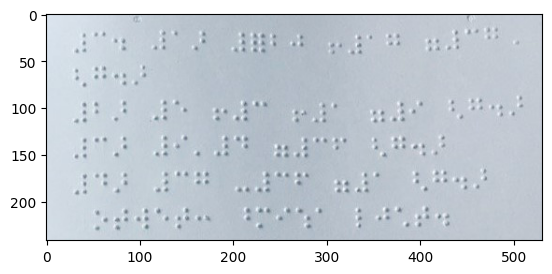

In [17]:
im = cv2.imread('braille.jpeg')
print(im.shape)
plt.imshow(im)

Podem veure el text en Braille. Com el que ens interessa no té que veure amb el color ho convertirem a B/N.

(242, 531)


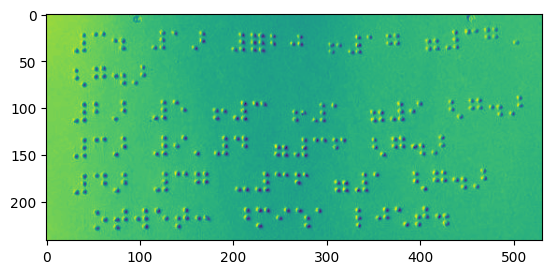

In [18]:
im_bn = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
print(im_bn.shape)
plt.imshow(im_bn)

## Processem la imatge

Per poder classificar els caràcters (semblant al que hem fet en el dataset MNIST) primer haurem d'extreure els caràcters.

Podriem utilitzar la detecció d'objectes (que veurem en una altra pràctica) pero en aquesta pràctica ho farem utilitzant _visió per computador_ pura.

### Thresolding

El primer pas serà fer _thresolding_ (separar el fons del primer plà). En aquest [article](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) podem veure ben descrit el procediment.

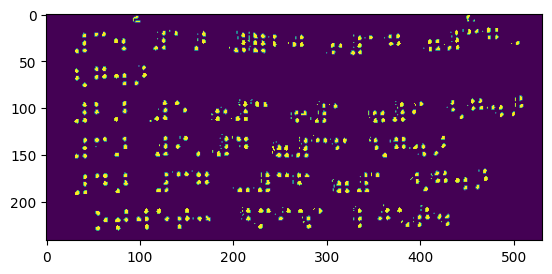

In [19]:
# En primer lloc emborronem la imatge per tal de reduir el soroll
im = cv2.blur(im_bn, (3, 3))

# Fem un thresholding per binaritzar la imatge, adaptant el threshold a cada píxel
# cv2.adaptiveThreshold: L'operació de thresholding s'aplica a cada píxel de la imatge, i el valor del threshold es calcula a partir dels valors dels píxels del veïnatge
# cv2.ADAPTIVE_THRESH_MEAN_C: el valor del threshold és la mitjana dels valors dels pixels del veïnatge
# cv2.THRESH_BINARY_INV: els pixels amb valor superior al threshold es posen a 0, els altres a 255
im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                           cv2.THRESH_BINARY_INV, 5, 4)
plt.imshow(im)

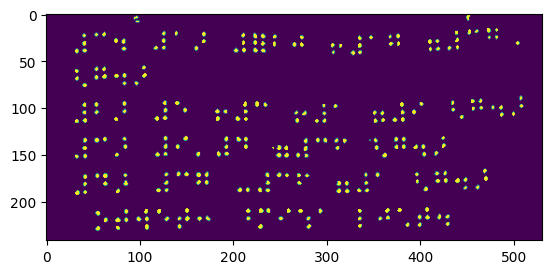

In [20]:

# cv2.medianBlur: El medianBlur és un filtre que substitueix el valor de cada píxel per la mediana dels valors dels píxels del veïnatge
im = cv2.medianBlur(im, 3)

# cv2.threshold: aplica un threshold a la imatge
# cv2.THRESH_OTSU: el threshold es calcula automàticament
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
plt.imshow(im)

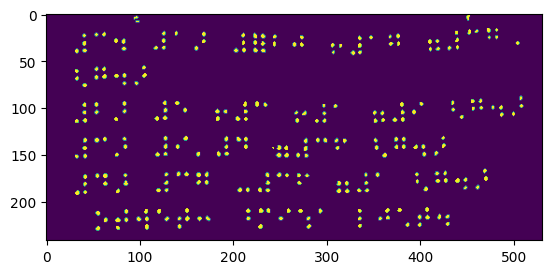

In [24]:
# cv2.GaussianBlur: aplica un filtre gaussià a la imatge. 
im = cv2.GaussianBlur(im, (3,3), 0)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
plt.imshow(im)

El mètode més senzill és el _Simple Thresholding_ que simplement compara cada pixel amb un valor i el converteix en blanc o negre segons si és més gran o més petit. Aquest mètode és el més senzill i el més ràpid. Nosaltres hem utilitzat una combinació de mètodes més avançats.

`im = cv2.blur(im_bn, (3, 3))`: Apliquem un _blur_ per suavitzar la imatge i eliminar soroll.

`im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 5, 4)`: Apliquem un _thresolding_ adaptatiu que ajusta el valor de _thresolding_ segons la mitjana dels pixels veïns.

`im = cv2.medianBlur(im, 3)`: El median blur és un altre mètode per suavitzar la imatge. Aquest mètode substitueix cada pixel per la mitjana dels pixels veïns.

`_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)`: Apliquem un _thresolding_ automàtic. Aquest mètode calcula el valor òptim de _thresolding_.

Per finalitzar apliquem un Gaussian Blur per suavitzar la imatge i tornem a fer el _thresolding_.


### Feature Extraction

Per extreure cada caràcter anem a utilitzar el _feature extraction_. El que fa es marcar en una serie de punts les característiques més significatives de la imatge. Aquestes característiques són les que ens permetran classificar els caràcters.

Hi ha molts mètodes per fer _feature extraction_ en aquest cas hem utilitzat el mètode ORB (Oriented FAST and Rotated BRIEF) que és un mètode ràpid i robust per trobar punts d'interès.

In [22]:
orb = cv2.ORB_create(5000) # Creem un objecte ORB amb 5000 punts clau
keypoints, descriptors = orb.detectAndCompute(im, None) # Detectem els punts clau

Per finalitzar mmostrem els punts d'interès en la imatge, per veure com ha funcionat el mètode.

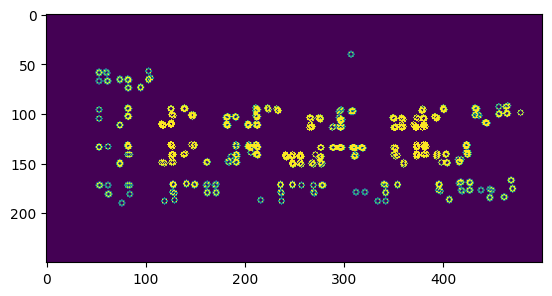

In [23]:
def pintar_punts(punts):
    img = np.zeros((250,500))
    for x in punts:
        cv2.circle(img,(int(x[0]),int(x[1])),3,(255,0,0))
    plt.imshow(img)

pts = [x.pt for x in keypoints]
pintar_punts(pts)  

### Extraiem els caràcters

En primer lloc llevarem els marges de la imatge per evitar problemes amb els caràcters que toquin els marges. Per fer-ho aprofitarem que ja hem extret els punts d'interès i buscarem els punts màxims i mínims de les coordenades `x` i `y` i deixarem un marge de 10 píxels.

53.28000259399414 40.80000305175781 445 170


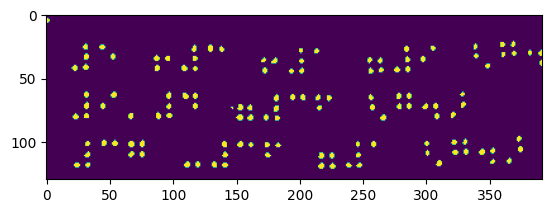

In [28]:
min_x, min_y = np.min(pts, axis=0)
max_x, max_y = np.max(pts, axis=0)

# Agregem una mica de marge
max_x = min(im.shape[1], max_x+10)
max_y = min(im.shape[0], max_y+10)
print(min_x, min_y, max_x, max_y)

# Retallem la imatge
im = im[int(min_y):int(max_y), int(min_x):int(max_x)]
plt.imshow(i

Per poder extreure els caràcters necessitem que els punts estiguen ben alineats. imatge està un poc torçada i necessitem corregir-ho. Per fer-ho farem el que s'anomena **canvi de perspectiva**. Aquesta operació consisteix en trobar una matriu de transformació que ens permeti canviar la perspectiva de la imatge.

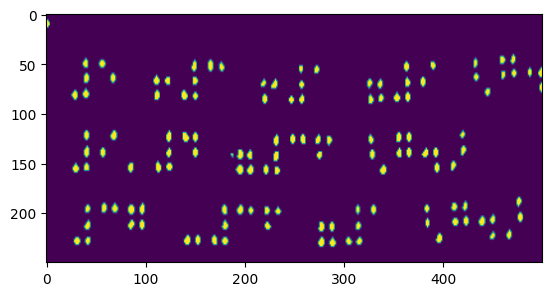